In [1]:
from ipywidgets import interact, IntSlider
import sys
%pylab inline
import matplotlib
matplotlib.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


## Inverse Problem

In [2]:
import numpy as np
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP, Utils as StaticUtils
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
from pymatsolver import PardisoSolver

# Setup tensor mesh

# Core cell sizes in x, y, and z
csx, csy, csz = 25., 25., 25.
# Number of core cells in each direction
ncx, ncy, ncz = 48, 48, 20
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
# Create mesh
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]

# Load synthetic conductivity model matching the designated mesh
sigma = mesh.readModelUBC("VTKout_DC.dat")
eta = mesh.readModelUBC("VTKout_eta.dat")
# Identify air cells in the model
airind = sigma == 1e-8

# Obtain topographic surface from 3D conductivity model
mesh2D, topoCC = StaticUtils.gettopoCC(mesh, airind)


# Setup gradient array survey

# Define the source electrode locations
# Here we use a single dipole source (A-B electrode) in the x-direction)
Aloc1_x = np.r_[-600., 0, 0.] + np.r_[xc, yc, zc]
Bloc1_x = np.r_[600., 0, 0.] + np.r_[xc, yc, zc]

# Rx locations (M-N electrodes, x-direction)
# Find x and y cell centres in the interior portion of the mesh
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300.+ xc, mesh.vectorCCx<300.+ xc)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300.+ yc, mesh.vectorCCy<300.+ yc)]
# Grid selected cell centres to get M and N Rx electrode locations
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
# Get cell ind for electrode locations to extract electrode elevation from topoCC
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
# Draped M and N electrode x,y,z locations
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]

# Create Src and Rx classes for DC problem
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
src1 = DC.Src.Dipole([rx_x], Aloc1_x, Bloc1_x)

# Use estimated conductivity model to compute sensitivity function
mapping = Maps.InjectActiveCells(mesh, ~airind, 0.)
problemIP = IP.Problem3D_CC(mesh, sigma=sigma, etaMap=mapping, storeJ=True)
problemIP.Solver = PardisoSolver
surveyIP = IP.Survey([src1])
problemIP.pair(surveyIP)

In [3]:
# Compute predicted data
IPdobs = surveyIP.dpred(eta[~airind])

>> Compute Sensitivity matrix
 0 / 1

In [4]:
IPobsData = Survey.Data(surveyIP, v=IPdobs)

In [5]:
# Setup IP inversion

# Depth weighting
depth = 1./(abs(mesh.gridCC[:,2]-zc))**1.5
depth = depth/depth.max()

# Assign uncertainties
std = 0.
eps = abs(IPdobs).max()*0.02
surveyIP.std = std
surveyIP.eps = eps
# Define initial and reference model
m0 = np.ones(mesh.nC)[~airind]*1e-4

# Setup inversion object
regmap = Maps.IdentityMap(nP=m0.size)
# Set observed data for inversion object
surveyIP.dobs = IPdobs
# Define datamisfit portion of objective function
dmisfit = DataMisfit.l2_DataMisfit(surveyIP)
# Define regulatization (model objective function)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind, cell_weights=depth[~airind])
# reg.wght = weight
opt = Optimization.ProjectedGNCG(maxIter = 30)
opt.lower = 0.
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Define inversion parameters
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()

savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, beta, save, target, savemodel])
reg.alpha_s = 1.
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problemIP.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

# Run IP inversion
mIPopt = inv.run(m0)

# Apply mapping to model to get and save recovered conductivity
etaopt = mapping*mIPopt

# Calculate dpred
IPdpred = invProb.dpred

# Set observed and predicted data as data objects
IPpredData = Survey.Data(surveyIP, v=invProb.dpred)
IPobsData = Survey.Data(surveyIP, v=IPdobs)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-07-25-17-12.txt'
SimPEG.SaveModelEveryIteration will save your models as: '###-InversionModel-2017-07-25-17-12.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.22e+09  2.33e+05  0.00e+00  2.33e+05    8.72e+07      0              
   1  3.22e+09  1.12e+04  7.77e-07  1.37e+04    7.55e+06      0              
   2  3.22e+09  6.34e+03  1.12e-06  9.96e+03    1.97e+06      0   Skip BFGS  
   3  6.44e+08  5.57e+03  1.23e-06  6.37e+03    1.96e+06      0              
   4  6.44e

### Plot true and recovered conductivity models to assess how well anomalous structures are recovered.

In [6]:
def compareTrueAndRecoveredModels(indz,indy):
    fig = plt.figure(figsize(11, 8))
    vmin, vmax = 0., 1.6
    xmin, xmax = -700+xc, 700+xc
    ymin, ymax = -700+yc, 700+yc
    zmin, zmax = -700+zc, 0+zc
#     indz = 28
#     indy = 31
    # Axis label
    x = np.linspace(xmin+200, xmax-200,3)

    # True Chargeability Model z-section
    ax1 = plt.subplot(1,1,1)
    pos =  ax1.get_position()
    ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
    ax1,dat1 = viz(mesh, eta*1e3, indz, airind, normal="Z", xc=xc,yc=yc,zc=zc, ax=ax1, scale="linear", cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax1.xaxis.set_visible(False)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)    
    ax1.set_ylabel('Northing (m)')

    # True Chargeability Model y-section
    pos =  ax1.get_position()
    ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax2, dat2 = viz(mesh, eta*1e3, indy, airind, normal="Y", xc=xc,yc=yc,zc=zc, ax=ax2, scale="linear", cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax2.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(zmin, zmax) 
    ax2.set_xticks(map(int, x))
    ax2.set_xticklabels(map(str, map(int, x)),size=12)
    ax2.set_xlabel('Easting (m)')
    ax2.set_ylabel('Elev. (m)')

    # IP Recovered Model z-section
    ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
    ax3,dat3 = ax = viz(mesh, etaopt*1e3, indz, airind, normal="Z", xc=xc,yc=yc,zc=zc, ax=ax3, scale="linear", cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax3.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)

    # IP Recovered Model y-section
    ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax4, dat4 = viz(mesh, etaopt*1e3, indy, airind,  normal="Y", xc=xc,yc=yc,zc=zc, ax=ax4, scale="linear", cb=False, clim=(vmin, vmax))
    plt.gca().set_aspect('equal')
    ax4.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax4.yaxis.set_visible(False)
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(zmin, zmax) 
    ax4.set_xticks(map(int, x))
    ax4.set_xticklabels(map(str, map(int, x)),size=12)
    ax4.set_xlabel('Easting (m)')

    pos =  ax4.get_position()
    cbarax = fig.add_axes([pos.x0+0.3 , pos.y0+0.095 ,  pos.width*0.1, pos.height*1.7])  ## the parameters are the specified position you set
    cb = fig.colorbar(dat1[0],cax=cbarax, orientation="vertical", ax = ax4, ticks=np.linspace(vmin,vmax, 4))

    cb.set_label("Chargeability (ms)",size=12)
    # fig.savefig('MAG_RecModel.png',dpi = 200)


In [7]:
def viz(mesh, sigma, ind, airind, normal="Z", ax=None, label="Conductivity (S/m)", scale="log", clim=(-4, -1), xc=0, yc=0,zc=0., cb=True):
    if normal == "Z":
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 5))
            ax = plt.subplot(111)
    else:
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 2.5))
            ax = plt.subplot(111)

    temp = sigma.copy()

    if scale == "log":
        temp = np.log10(temp)

    temp[airind] = np.nan

    dat = mesh.plotSlice(temp, ind=ind, clim=clim, normal=normal, grid=False, pcolorOpts={"cmap":"viridis"}, ax=ax)
    if normal == "Z":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Northing (m)")
        xmin, xmax = -500+xc, 500+xc
        ymin, ymax = -500+yc, 500.+yc
        ax.set_title(("Elevation at %.1f m")%(mesh.vectorCCz[ind]))
    elif normal == "Y":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Elevation (m)")
        xmin, xmax = -500+xc, 500+xc
        ymin, ymax = -500+zc, 0.+zc
        ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[ind]))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # plt.tight_layout()

    if scale == "log":
        cbformat = "$10^{%1.1f}$"
    elif scale == "linear":
        cbformat = "%.1e"

    if clim is None:
        vmin, vmax = dat[0].get_clim()
    else:
        vmin, vmax = clim[0], clim[1]

    if cb:
        cb = plt.colorbar(dat[0], format=cbformat, ticks=np.linspace(vmin, vmax, 3))
        cb.set_label(label)
    # plt.show()
    return ax, dat

<function __main__.<lambda>>

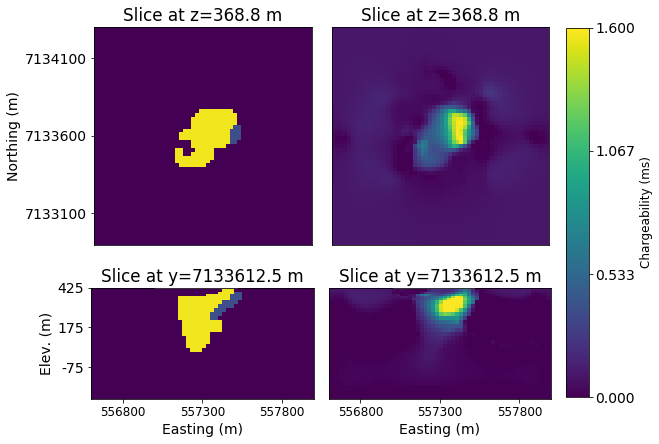

In [8]:
interact(lambda indz,indy: compareTrueAndRecoveredModels(indz,indy), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=31))

### Plot observed and predicted data to evaluate how well the recovered model fits the observed data.

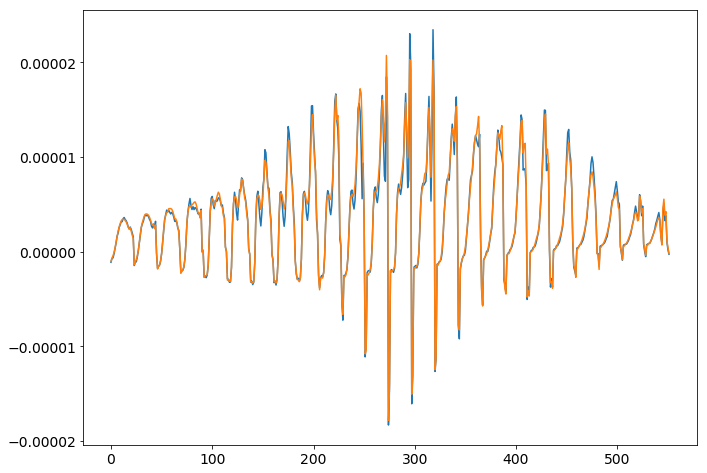

In [9]:
plt.plot(IPdpred)
plt.plot(IPdobs)

In [10]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None, cb=True,cbOrient="vertical"):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()            
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)            
    
    if cb:
        cb = plt.colorbar(dat, orientation=cbOrient, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
        cb.set_label("Potential (V)")
        
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    return ax

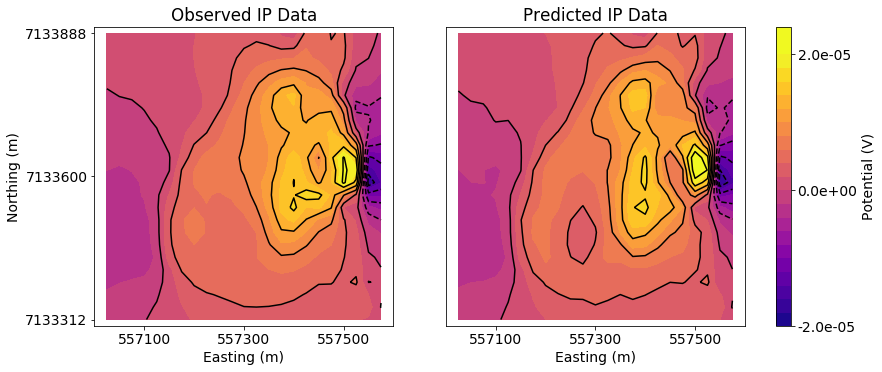

In [11]:
fig = plt.figure(figsize(11, 5.5))
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
indz = 28

# Axis label
x = np.linspace(xmin+100, xmax-100,3)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")

# DC observed data
ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0-0.4, pos.y0,  pos.width, pos.height])
ax1 = vizdata(IPobsData, src1, rx_x, ax=ax1, rxcomponent="X", title="Observed IP Data", cb=False,clim=(-2e-5,2e-5))
plt.gca().set_aspect('equal')
# ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax1.xaxis.set_visible(False)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)   
ax1.set_xticks(map(int, x))
ax1.set_xticklabels(map(str, map(int, x)),size=14)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')

# DC Predicted data
ax2 = fig.add_axes([pos.x0, pos.y0,  pos.width, pos.height])
ax2 = vizdata(IPpredData, src1, rx_x, ax=ax2, rxcomponent="X", title="Predicted IP Data",clim=(-2e-5,2e-5))
plt.gca().set_aspect('equal')
ax2.yaxis.set_visible(False)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=14)
ax2.set_xlabel('Easting (m)')